In [ ]:
from __future__ import print_function, division
from builtins import range, input

In [ ]:
from keras.layers import Input, Lambda,Dropout,Dense, Flatten
from keras.models import Model
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from glob import glob

In [ ]:
IMAGE_SIZE = [128,128]

In [ ]:
# training config:
epochs = 11
batch_size = 70

In [ ]:
datapath = '/content/drive/MyDrive/FinalCse499/dataset'
outputModel = '/content/drive/MyDrive/FinalCse499/Video_Predict_Model_RS50/videoPredictModel/'
outputLabelBinarizer = '/content/drive/MyDrive/FinalCse499/modelRS50/VideoClassificationBinarizer'

In [ ]:
datapath

'/content/drive/MyDrive/FinalCse499/dataset'

In [ ]:
train_path = '/content/drive/MyDrive/FinalCse499/dataset/train'
test_path = '/content/drive/MyDrive/FinalCse499/dataset/test'

In [ ]:
test_path

'/content/drive/MyDrive/FinalCse499/dataset/test'

In [ ]:
train_path

'/content/drive/MyDrive/FinalCse499/dataset/train'

In [ ]:
import os

In [ ]:
os.listdir(train_path)

['Convocation', 'Meeting', 'Violence', 'Wedding', 'Boishak']

In [ ]:
image_files = glob(train_path + '/*/*.jp*g')

In [ ]:
image_files2 = glob(train_path + '/*/*.png')

In [ ]:
len(image_files)

24389

In [ ]:
len(image_files2)

0

In [ ]:
valid_image_files = glob(test_path + '/*/*.jp*g')

In [ ]:
valid_image_files2 = glob(test_path + '/*/*.png')

In [ ]:
len(valid_image_files)

1279

In [ ]:
len(valid_image_files2)

0

In [ ]:
# useful for getting number of classes
folders = glob(train_path + '/*')

In [ ]:
folders

['/content/drive/MyDrive/FinalCse499/dataset/train/Convocation',
 '/content/drive/MyDrive/FinalCse499/dataset/train/Meeting',
 '/content/drive/MyDrive/FinalCse499/dataset/train/Violence',
 '/content/drive/MyDrive/FinalCse499/dataset/train/Wedding',
 '/content/drive/MyDrive/FinalCse499/dataset/train/Boishak']

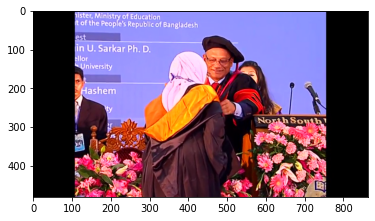

In [ ]:
# look at an image for fun
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [ ]:
IMAGE_SIZE + [3]

[128, 128, 3]

In [ ]:
from keras.applications.resnet import ResNet50

In [ ]:
# add preprocessing layer to the front of VGG
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# don't train existing weights
for layer in res.layers:
    layer.trainable = False

In [ ]:
# our layers - you can add more if you want
x = Flatten()(res.output)
x = Dense(300, activation='relu')(x)
x=Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x=Dropout(0.5)(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=res.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [ ]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [ ]:
test_gen = gen.flow_from_directory(test_path, target_size=IMAGE_SIZE)

Found 1279 images belonging to 5 classes.


In [ ]:
print(test_gen.class_indices)

{'Boishak': 0, 'Convocation': 1, 'Meeting': 2, 'Violence': 3, 'Wedding': 4}


In [ ]:
labels = [None] * len(test_gen.class_indices)
print(labels)

[None, None, None, None, None]


In [ ]:
for k, v in test_gen.class_indices.items():
    labels[v] = k

In [ ]:
labels

['Boishak', 'Convocation', 'Meeting', 'Violence', 'Wedding']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -123.68 max: 151.04895


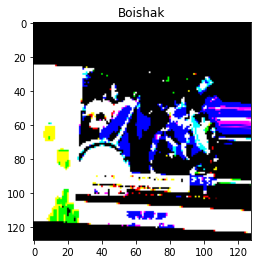

In [ ]:
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=1)

In [ ]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

valid_generator = gen.flow_from_directory(
  test_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 24389 images belonging to 5 classes.
Found 1279 images belonging to 5 classes.


In [ ]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
  
)

Epoch 1/11
206/348 [================>.............] - ETA: 43:31 - loss: 2.5391 - accuracy: 0.5400

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


348/348 [==============================] - 6679s 19s/step - loss: 1.9283 - accuracy: 0.5932 - val_loss: 0.8258 - val_accuracy: 0.7048
Epoch 2/11
348/348 [==============================] - 1591s 5s/step - loss: 0.8185 - accuracy: 0.7520 - val_loss: 0.8005 - val_accuracy: 0.7214
Epoch 3/11
348/348 [==============================] - 1579s 5s/step - loss: 0.6364 - accuracy: 0.8141 - val_loss: 0.5616 - val_accuracy: 0.8087
Epoch 4/11
348/348 [==============================] - 1580s 5s/step - loss: 0.4882 - accuracy: 0.8562 - val_loss: 0.5766 - val_accuracy: 0.8246
Epoch 5/11
348/348 [==============================] - 1578s 5s/step - loss: 0.4391 - accuracy: 0.8731 - val_loss: 0.4878 - val_accuracy: 0.8310
Epoch 6/11
348/348 [==============================] - 1580s 5s/step - loss: 0.4004 - accuracy: 0.8869 - val_loss: 0.4888 - val_accuracy: 0.8500
Epoch 7/11
348/348 [==============================] - 1573s 5s/step - loss: 0.3729 - accuracy: 0.8970 - val_loss: 0.5306 - val_accuracy: 0.8476
Ep

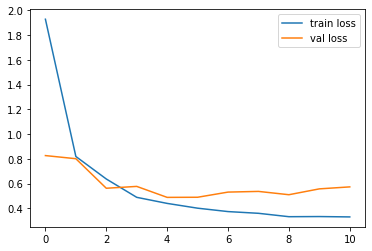

In [ ]:
# loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

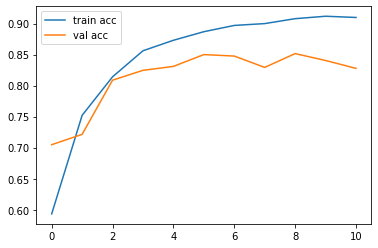

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/FinalCse499/RS50model3.h5')


In [ ]:
import pickle

In [ ]:
lbinarizer = open('/content/drive/MyDrive/FinalCse499/modelRS50/VideoClassificationBinarizer.pickle','wb')
lbinarizer.write(pickle.dumps(labels))
lbinarizer.close()